In [16]:
import numpy as np
from scipy import signal
from keras.datasets import mnist
from keras.utils import np_utils

In [17]:
#layer.py
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        # TODO: return output
        pass

    def backward(self, output_gradient, learning_rate):
        # TODO: update parameters and return input gradient
        pass

In [18]:
#dense.py
class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input) + self.bias

    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(output_gradient, self.input.T)
        input_gradient = np.dot(self.weights.T, output_gradient)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        return input_gradient

In [19]:
#convolutional.py
class Convolutional(Layer):
    def __init__(self, input_shape, kernel_size, depth):
        input_depth, input_height, input_width = input_shape
        self.depth = depth
        self.input_shape = input_shape
        self.input_depth = input_depth
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)
        self.kernels = np.random.randn(*self.kernels_shape)
        self.biases = np.random.randn(*self.output_shape)

    def forward(self, input):
        self.input = input
        self.output = np.copy(self.biases)
        for i in range(self.depth):
            for j in range(self.input_depth):
                self.output[i] += signal.correlate2d(self.input[j], self.kernels[i, j], "valid")
        return self.output

    def backward(self, output_gradient, learning_rate):
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient = np.zeros(self.input_shape)

        for i in range(self.depth):
            for j in range(self.input_depth):
                kernels_gradient[i, j] = signal.correlate2d(self.input[j], output_gradient[i], "valid")
                input_gradient[j] += signal.convolve2d(output_gradient[i], self.kernels[i, j], "full")

        self.kernels -= learning_rate * kernels_gradient
        self.biases -= learning_rate * output_gradient
        return input_gradient

In [20]:
#reshape.py
class Reshape(Layer):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, input):
        return np.reshape(input, self.output_shape)

    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient, self.input_shape)

In [21]:
#activation.py
class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(self.input)

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))

In [22]:
#activations.py
class Tanh(Activation):
    def __init__(self):
        def tanh(x):
            return np.tanh(x)

        def tanh_prime(x):
            return 1 - np.tanh(x) ** 2

        super().__init__(tanh, tanh_prime)

class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def sigmoid_prime(x):
            s = sigmoid(x)
            return s * (1 - s)

        super().__init__(sigmoid, sigmoid_prime)

class ReLU(Activation):
    def __init__(self):
        def relu(x):
            return np.maximum(0, x)

        def relu_prime(x):
            return np.where(x > 0, 1, 0)

        super().__init__(relu, relu_prime)

class Softmax(Layer):
    def forward(self, input):
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        # This version is faster than the one presented in the video
        n = np.size(self.output)
        return np.dot((np.identity(n) - self.output.T) * self.output, output_gradient)
        # Original formula:
        # tmp = np.tile(self.output, n)
        # return np.dot(tmp * (np.identity(n) - np.transpose(tmp)), output_gradient)

class Linear(Activation):
    def __init__(self):
        def linear(x):
            return x

        def linear_prime(x):
            return 1 
        
        super().__init__(linear, linear_prime)

In [23]:
#losses.py
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

def binary_cross_entropy(y_true, y_pred):
    return np.mean(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_prime(y_true, y_pred):
    return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)

In [50]:
import matplotlib.pyplot as plt

def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

def train(network,network1,loss, loss_prime, x_train, y_train, epochs = 1000, learning_rate = 0.01, verbose = True):
    error_values = []
    error_values1 = []
    net=[]
    for e in range(epochs):
        error = 0
        for x, y in zip(x_train, y_train):
            # forward
            output = predict(network, x)

            # error
            error += loss(y, output)

            # backward
            grad = loss_prime(y, output)
            for layer in reversed(network):
                grad = layer.backward(grad, learning_rate)

        error /= len(x_train)
        error_values.append(error)
        if verbose:
            print(f"{e + 1}/{epochs}, error={error}")
 
    for e in range(epochs):
        error1 = 0
        for x, y in zip(x_train, y_train):
            # forward
            output1 = predict(network1, x)

            # error
            error1 += loss(y, output1)

            # backward
            grad = loss_prime(y, output1)
            for layer in reversed(network1):
                grad = layer.backward(grad, learning_rate)

        error1 /= len(x_train)
        error_values1.append(error1)
        if verbose:
            print(f"{e + 1}/{epochs}, error={error1}")
    
    # Plot error over epochs
    plt.plot(error_values)
    plt.plot(error_values1)
    plt.title('Error over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.show()




In [25]:
#preprocess data
def preprocess_data(x, y, limit):
    zero_index = np.where(y == 0)[0][:limit]
    one_index = np.where(y == 1)[0][:limit]
    all_indices = np.hstack((zero_index, one_index))
    all_indices = np.random.permutation(all_indices)
    x, y = x[all_indices], y[all_indices]
    x = x.reshape(len(x), 1, 28, 28)
    x = x.astype("float32") / 255
    y = np_utils.to_categorical(y)
    y = y.reshape(len(y), 2, 1)
    return x, y


1/100, error=0.7293383088138953
2/100, error=0.052188348310141276
3/100, error=0.025244331816018543
4/100, error=0.04715016160902403
5/100, error=0.005988398750530481
6/100, error=0.0020581353600502656
7/100, error=0.001349001648041139
8/100, error=0.0010609303764246784
9/100, error=0.000891116492530938
10/100, error=0.0007376712813727274
11/100, error=0.0006558406341362625
12/100, error=0.0006005118048309083
13/100, error=0.0005543733830475325
14/100, error=0.0005176324250858479
15/100, error=0.0004855508809266068
16/100, error=0.000453797456468329
17/100, error=0.00041773033717121743
18/100, error=0.00036404470886273956
19/100, error=0.00026037937564839334
20/100, error=0.00021945855561593958
21/100, error=0.00020484884853878263
22/100, error=0.00019539953163580658
23/100, error=0.00018856625638947604
24/100, error=0.00018321970673334305
25/100, error=0.00017878395662909298
26/100, error=0.00017494153039674328
27/100, error=0.00017150917265770587
28/100, error=0.00016837571911241958


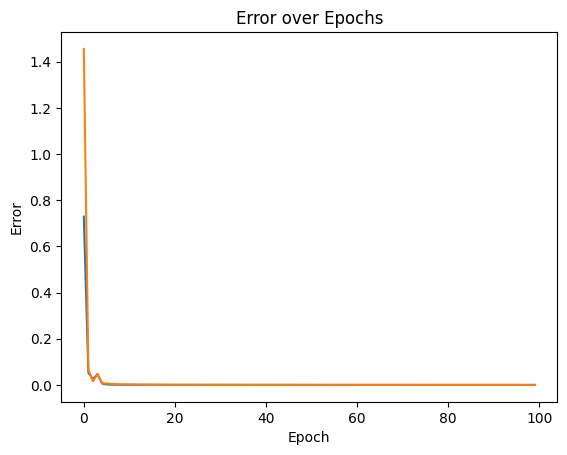

In [51]:
# driver code1 for mnist binary classification using convolutional
# neural netwwwork
# load MNIST from server, limit to 100 images per class since we're not training on GPU
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = preprocess_data(x_train, y_train, 100)
x_test, y_test = preprocess_data(x_test, y_test, 100)

# neural network
network = [
    Convolutional((1, 28, 28), 3, 5),
    ReLU(),
    Reshape((5, 26, 26), (5 * 26 * 26, 1)),
    Dense(5 * 26 * 26, 100),
    Sigmoid(),
    Dense(100, 2),
    Softmax()
]

network1 = [
    Convolutional((1, 28, 28), 3, 5),
    Sigmoid(),
    Reshape((5, 26, 26), (5 * 26 * 26, 1)),
    Dense(5 * 26 * 26, 100),
    Sigmoid(),
    Dense(100, 2),
    Softmax()
]

# train
train(
    network,
    network1,
    binary_cross_entropy,
    binary_cross_entropy_prime,
    x_train,
    y_train,
    epochs=100,
    learning_rate=0.1
)




In [27]:
# driver code1 testing
# test
for x, y in zip(x_test, y_test):
    output = predict(network, x)
    print(f"pred: {np.argmax(output)}, true: {np.argmax(y)}")

<ipython-input-22-1f5853839258>:15: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true:

In [28]:
from sklearn.metrics import accuracy_score
y_pred = []
y_true = []
for x, y in zip(x_test, y_test):
    output = predict(network, x)
    y_pred.append(np.argmax(output))
    y_true.append(np.argmax(y))
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy score:", accuracy)

Accuracy score: 0.995


<ipython-input-22-1f5853839258>:15: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


In [29]:
correct=0
for x, y in zip(x_test, y_test):
    output = predict(network, x)
    print(f"pred: {np.argmax(output)}, true: {np.argmax(y)}")
    if np.argmax(output)==np.argmax(y):
        #print("inside if")
        correct=correct+1
accuracy=correct/len(y_test)
print("accuracy: ",accuracy*100)
print("correct: ",correct)

<ipython-input-22-1f5853839258>:15: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true:

1/20, error=0.4877966975739756
2/20, error=0.23149349826851054
3/20, error=0.18241356173580991
4/20, error=0.14732856620538218
5/20, error=0.12249617018412742
6/20, error=0.10527726323153319
7/20, error=0.09148933333288536
8/20, error=0.07976723992888496
9/20, error=0.0697754773668065
10/20, error=0.06093357635414475
11/20, error=0.054025380267062745
12/20, error=0.04861724023411705
13/20, error=0.044507470410281164
14/20, error=0.041316206804023974
15/20, error=0.03857982459069048
16/20, error=0.03617485364808989
17/20, error=0.03404206126180244
18/20, error=0.03213773965738638
19/20, error=0.03042822753014256
20/20, error=0.028886497211976402


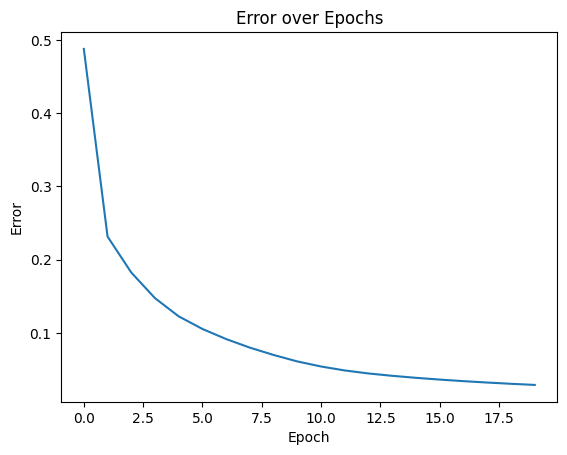

In [30]:
# driver code1 for mnist binary classification using convolutional
# neural netwwwork
# load MNIST from server, limit to 100 images per class since we're not training on GPU
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = preprocess_data(x_train, y_train, 100)
x_test, y_test = preprocess_data(x_test, y_test, 100)

# neural network
network = [
    Convolutional((1, 28, 28), 3, 5),
    Sigmoid(),
    Reshape((5, 26, 26), (5 * 26 * 26, 1)),
    Dense(5 * 26 * 26, 100),
    Sigmoid(),
    Dense(100, 2),
    Sigmoid()
]

# train


train(
    network,
    binary_cross_entropy,
    binary_cross_entropy_prime,
    x_train,
    y_train,
    epochs=20,
    learning_rate=0.01,
    verbose=True
)